# DATOS DE MERCADO DE VALORES (índice S&P 500)

---


*   El índice Standard & Poor's 500, también conocido como S&P 500, es uno de los índices bursátiles más importantes de Estados Unidos. Al S&P 500 se lo considera el índice más representativo de la situación real del mercado (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
*   Lista de empresas que forman parte del índice Dow Jones Industrial Average de https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average



---
Tomaremos los datos publicados en https://www.kaggle.com/camnugent/sandp500

La data (CSV) tiene las siguientes columnas: Fecha - en formato: yy-mm-dd



*   OPEN-Abierto - precio de la acción en el mercado abierto (estos son datos de NYSE, así que todo en USD)
*   HIGH - Alto - Precio más alto alcanzado en el día
*   Low Close - Precio más bajo alcanzado en el día
*   Volumen - Número de acciones negociadas   
*   nombre: el nombre del ticker de la acción

##instalando librerias

In [ ]:
# necesitamos la libreria WIKITABLES para descargar tablas de Wikipedia (y mantener actualizada la data)
# Necesitamos la libreria FSSPEC (Interfaces de sistema de archivos para Python)
# Necesitamos la libreria  beautifulsoup4 : para raspado web altamente evolucionadas
!pip install wikitables
!pip install fsspec
!pip install beautifulsoup4 

     |████████████████████████████████| 176 kB 5.3 MB/s 
     |████████████████████████████████| 10.1 MB 14.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=158931de5418c3a43b5882a0d63ebe7b16d215a57d5d7561696a17d21f6dad27
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built pycountry
     |████████████████████████████████| 134 kB 5.1 MB/s 


##Importando librerías

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D   #para graficas en 3D

import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

#from wikitables import import_tables    # para descargar tablas de Wikipedia
from sklearn.decomposition import PCA   # Análisis de componentes principales (PCA).

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##importando dataset

In [ ]:
df_acciones = pd.read_csv("https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/1-Machine_Learning_Classic/Databasets/K_means_indice_S%26P_500.csv")
df_acciones.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## conociendo y Preprocesando los datos



Vamos a usar datos semanales desde 2013 a 2018, donde cada acción tiene su propio rango de valores. Por ejemplo:
 

*   Apple (APPL) empieza en $67.85

*   Adobe (ADBE) en $39.12.

---

La intención de este ejercicio es agrupar las acciones por el comportamiento de sus ganancias, en vez de por su precio de mercado. De esta forma el rendimiento de cada acción es comparable con los demás.


In [ ]:
#df_acciones.shape
#df_acciones.info()
#df_acciones.describe()
df_acciones.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

###Eliminando filas vacias
---

eliminamos los datos vacíos (NA) y resetamos el índice

In [ ]:
df_acciones = df_acciones.dropna()   # Se eliminan filas que tengan valor NaN.
df_acciones = df_acciones.reset_index(drop=True)

###cambiando el tipo de dato en columnas

In [ ]:
df_acciones['date']=pd.to_datetime(df_acciones['date'])       # Convertimos el campo DATE en tipo fecha
df_acciones = df_acciones.rename(columns={'Name':'symbol'})   #cambiamos el nombre la col de NAME a  SYMBOL
df_acciones.head()

,date,open,high,low,close,volume,symbol
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


###Descargamos la lista de las 500 compañias S&P 

---

Descargamos la tabla de wikipedia [ https://en.wikipedia.org/wiki/List_of_S%26P_500_companies ] y la guárdamos para su uso posterior

In [ ]:
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_companies=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe
df_companies.to_csv('companies.csv', index_label='row')
df_companies.head()


200


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


###Descargamos la lista de las empresas que cotizan con el índice bursáil DOW JONES DJIA 

---

Descargamos la tabla de wikipedia [https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average] y la guárdamos para su uso posterior

In [ ]:
wikiurl="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"   # pagina de wikipedia donde esta la tabla
table_class="wikitable sortable jquery-tablesorter"                   # clase de la tabla
response=requests.get(wikiurl)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
indiatable=soup.find('table',{'id':"constituents"})                   # buscamos el objecto puede ser por la clase o por el ID
df_list_table=pd.read_html(str(indiatable))                           # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df_DowJones=pd.DataFrame(df_list_table[0])                            # convertimos la lista en un dataframe
df_DowJones.to_csv('DowJones.csv', index_label='row')
df_DowJones.head()

200


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.02%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.60%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.25%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.96%


In [ ]:
df_DowJones.info()
df_DowJones.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Company          30 non-null     object
 1   Exchange         30 non-null     object
 2   Symbol           30 non-null     object
 3   Industry         30 non-null     object
 4   Date added       30 non-null     object
 5   Notes            5 non-null      object
 6   Index weighting  30 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
count,30,30,30,30,30,5,30
unique,30,2,30,20,18,5,30
top,3M,NYSE,MMM,Information technology,2013-09-20,As Minnesota Mining and Manufacturing,3.02%
freq,1,23,1,5,3,1,1


###definidiendo que columnas usaremos para el ejercicio

---
Para este análisis, no solo consideremos la fecha, el precio al cierre y el símbolo.


In [ ]:
df_acciones = df_acciones[['date', 'close', 'symbol']]
df_acciones.head()

,date,close,symbol
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL


In [ ]:
df_acciones.shape

(619029, 3)

###invertir el dataframe para tener las acciones por fecha y por empresa

colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda

In [ ]:
#colocamos como indice la fecha, como columnas los iniciales de las empresas y como valor el CLOSE de cada celda
df_acciones = df_acciones.pivot(index='date', columns='symbol', values='close')
df_acciones = df_acciones.dropna(axis=1)    #borramos filas vacias
df_acciones.head(5)

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


###Normalización de los datos usando como base la fecha

---
Puede decidir volver a muestrear los datos:

*  W - para datos semanales
*  M - para datos mensuales
*  Q - para el trimestre
*  A - por año

In [ ]:
df_acciones = df_acciones.resample('W').last()
df_acciones.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.120,45.700,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-17,42.25,14.50,79.00,65.7371,37.58,46.60,35.08,74.16,38.635,46.175,...,28.67,38.12,88.36,42.80,31.88,28.28,63.99,75.90,24.34,33.98
2013-02-24,41.80,13.57,79.21,64.4014,38.46,46.95,34.55,74.80,38.550,45.520,...,28.99,37.96,89.20,41.78,32.48,27.79,65.45,74.14,24.04,32.59
2013-03-03,41.93,13.61,76.37,61.4957,37.81,47.98,33.60,74.82,39.830,45.230,...,28.82,36.65,89.43,41.16,32.60,27.49,65.21,74.99,24.04,34.60
2013-03-10,43.03,14.92,76.84,61.6742,37.34,48.48,34.68,78.35,41.500,46.050,...,29.66,38.37,88.97,42.74,34.84,28.43,67.72,75.40,25.30,34.09


##Graficando datos

---



1.   crear funcion para traer los nombres de la empresa 




In [ ]:
#funcion para sacar el  nombre de las empresas segun  su sigla
def get_name(symbol):
    name = symbol
    try:
        name= df_companies.loc[df_companies['Symbol'] == symbol]['Security'].values[0]
    except:
        name='No tiene nombre el simbolo'
    return name

def plot_stock(symbol, df_acciones=df_acciones):
    name = str(get_name(symbol))
    df_acciones[symbol].plot(title=name, label=name, alpha=0.9);

In [ ]:
get_name('AAL')

'American Airlines Group'

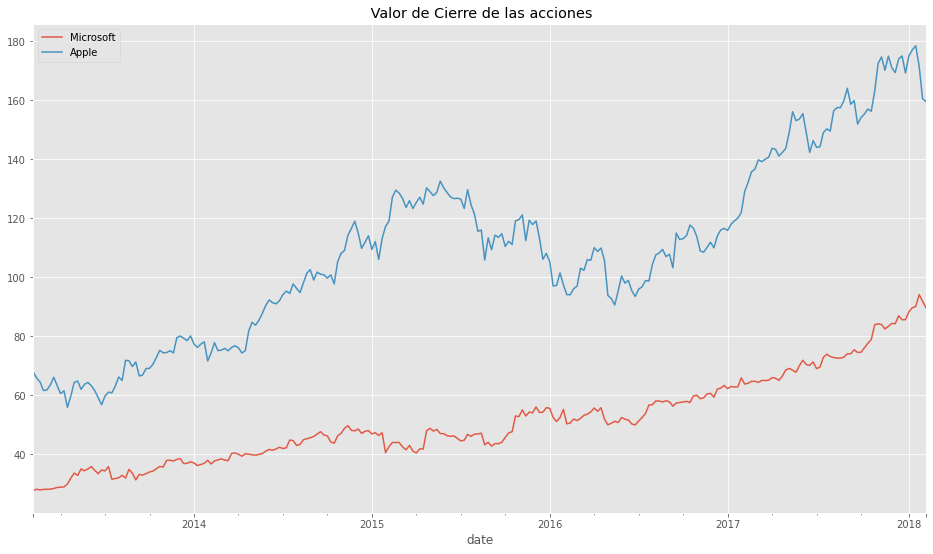

In [ ]:
plot_stock('MSFT')
plot_stock('AAPL')
plt.title(' Valor de Cierre de las acciones')
plt.legend();

###Calcular los rendimientos para que podamos comparar las acciones

---
Calcularemos la devolución desde el primer día de la compra. Por lo tanto, el rendimiento de un día determinado es cuánto se ganaría (o perdería), en porcentaje, si las acciones se vendieran en este día (los costos de transacción no se consideran)


In [ ]:
#df_acciones.head()
start = df_acciones.iloc[0]  #traemos la primera fila y la volvemos un vector
#calculamos el valor del retorno de la acción
returns = (df_acciones - start) / start
returns

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-02-17,-0.062777,-0.016949,0.001267,-0.031201,0.036690,-0.006185,0.019471,0.011595,-0.012398,0.010394,...,0.015227,0.016262,-0.002821,-0.001633,0.001256,0.043928,-0.020061,0.000659,0.008285,0.028139
2013-02-24,-0.072760,-0.080000,0.003929,-0.050886,0.060966,0.001280,0.004069,0.020325,-0.014571,-0.003939,...,0.026558,0.011997,0.006658,-0.025426,0.020101,0.025840,0.002297,-0.022544,-0.004143,-0.013918
2013-03-03,-0.069876,-0.077288,-0.032066,-0.093708,0.043034,0.023246,-0.023540,0.020597,0.018149,-0.010284,...,0.020538,-0.022927,0.009254,-0.039888,0.023869,0.014766,-0.001378,-0.011338,-0.004143,0.046899
2013-03-10,-0.045475,0.011525,-0.026109,-0.091078,0.030069,0.033909,0.007847,0.068749,0.060838,0.007659,...,0.050283,0.022927,0.004063,-0.003032,0.094221,0.049465,0.037060,-0.005933,0.048053,0.031467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-14,0.591171,2.964068,0.469455,1.609861,1.768000,1.111324,0.709968,1.184013,3.985941,1.013567,...,0.256728,0.990403,-0.012301,0.534640,0.029209,1.600960,0.280551,0.609756,1.207125,1.281089
2018-01-21,0.620896,2.936271,0.483143,1.630051,1.886621,1.133930,0.723627,1.206384,4.003323,1.103720,...,0.255312,1.018395,-0.016477,0.445066,-0.001256,1.654485,0.283461,0.627950,1.225766,1.318306
2018-01-28,0.659716,2.597966,0.567047,1.527625,2.398897,1.249520,0.843069,1.217296,4.145706,1.053392,...,0.298513,0.917889,0.004401,0.465827,0.031093,1.746770,0.320061,0.664206,1.237780,1.423298


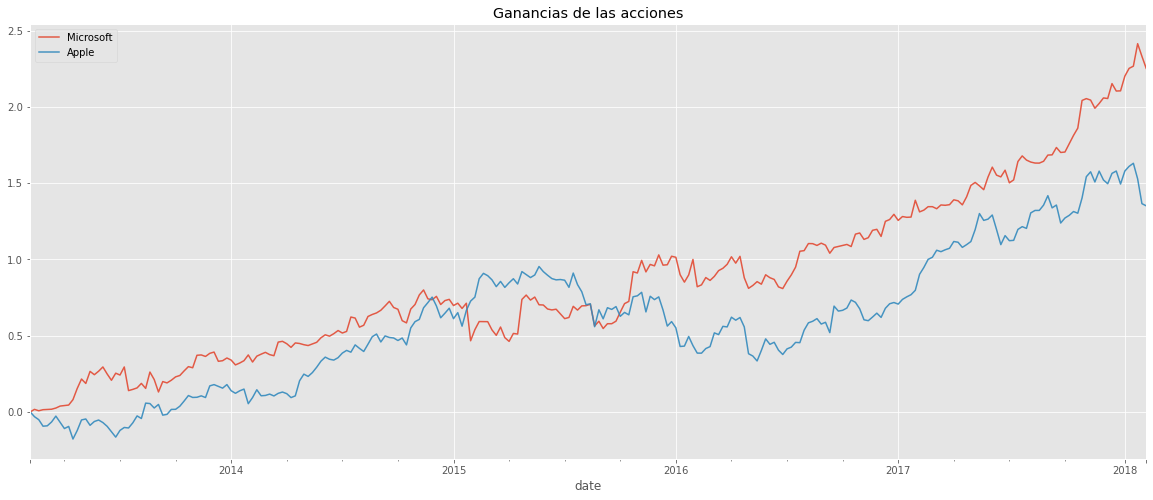

In [ ]:
plt.figure(figsize = (20,8))
plot_stock('MSFT', df_acciones=returns)
plot_stock('AAPL', df_acciones=returns)
plt.title('Ganancias de las acciones')
plt.legend();

###¿Cuáles fueron las acciones de mejor y peor desempeño?

### las mejores y las peores 5 empresas con retorno

In [ ]:
best = returns.iloc[-1].sort_values(ascending=False).head() # traemos las acciones mejor ordenadas
worst = returns.iloc[-1].sort_values().head()   #traemos las acciones con el orden inverso (las peores)
print ('--------peores--> ', worst.shape)
print(worst)
print ('--------mejores--> ',best.shape)
print(best)

--------peores-->  (5,)
symbol
CHK     -0.857143
RRC     -0.818157
DISCA   -0.676508
DISCK   -0.660217
MOS     -0.588762
Name: 2018-02-11 00:00:00, dtype: float64
--------mejores-->  (5,)
symbol
NVDA    17.496362
NFLX     9.233321
ALGN     6.159487
EA       6.084053
STZ      5.723705
Name: 2018-02-11 00:00:00, dtype: float64


####Las mejores

In [ ]:
print('____mejor rendimiento de las acciones_____')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in best.index.tolist()]}, index = best.index)
best = pd.concat((best, names), axis=1)
best.head()

____mejor rendimiento de las acciones_____


,2018-02-11 00:00:00,name
symbol,,
NVDA,17.496362,Nvidia
NFLX,9.233321,Netflix
ALGN,6.159487,Align
EA,6.084053,Electronic Arts
STZ,5.723705,Constellation Brands


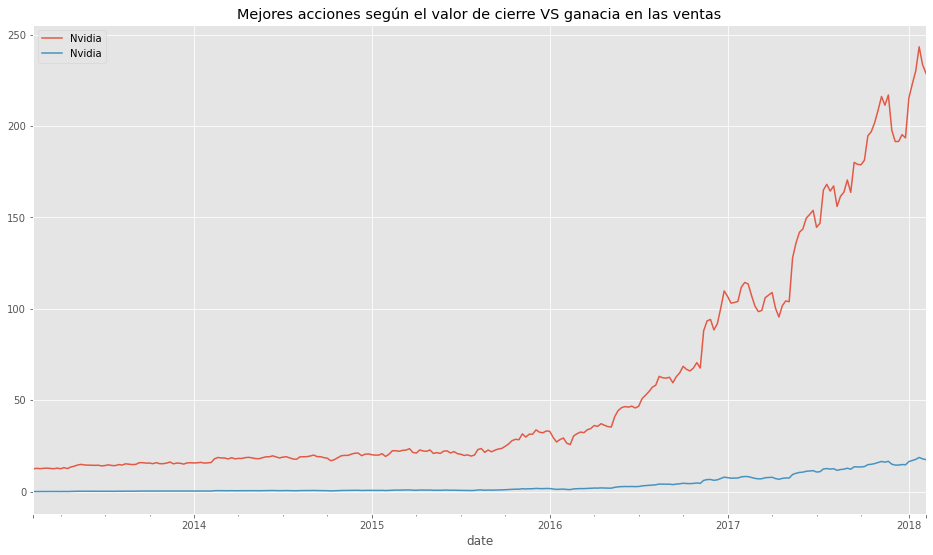

In [ ]:
plot_stock('NVDA')
plot_stock('NVDA', df_acciones=returns)
plt.title('Mejores acciones según el valor de cierre VS ganacia en las ventas')
plt.legend();

####las peores

In [ ]:
print('Peores perdidas de acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in worst.index.tolist()]}, index = worst.index)
worst = pd.concat((worst, names), axis=1)
worst

Peores perdidas de acciones


,2018-02-11 00:00:00,name
symbol,,
CHK,-0.857143,No tiene nombre el simbolo
RRC,-0.818157,No tiene nombre el simbolo
DISCA,-0.676508,Discovery (Series A)
DISCK,-0.660217,Discovery (Series C)
MOS,-0.588762,Mosaic


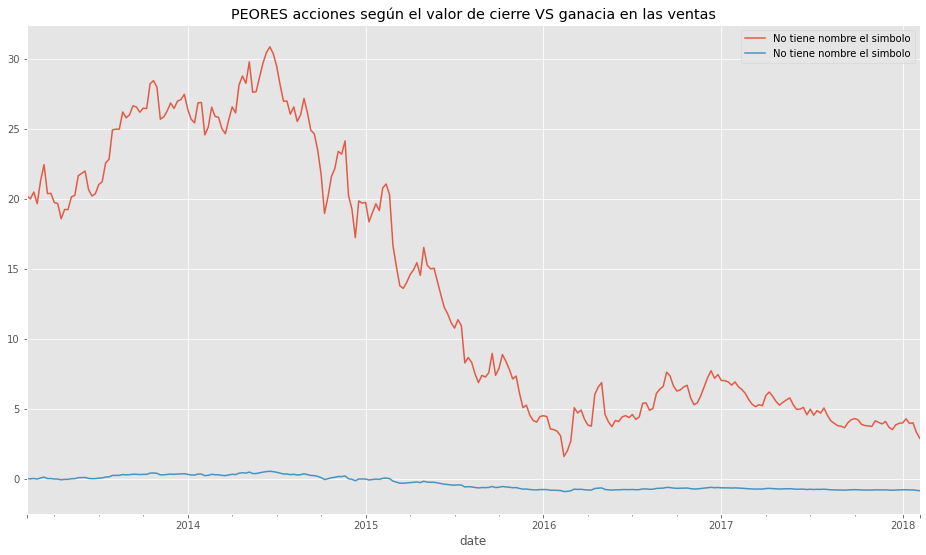

In [ ]:
plot_stock('CHK')
plot_stock('CHK', df_acciones=returns)
plt.title('PEORES acciones según el valor de cierre VS ganacia en las ventas')
plt.legend();

##Conociendo el indice de acciones del DOWN JONES

In [ ]:
#cargamos en una lista las acciones de las empresas que se riguen por el indice del DOWN JONES
down_acciones = [s for s in df_DowJones['Symbol'] if s in df_acciones.columns]  
dow_returns = returns[df_DowJones]   #calculamos las ganancias 
dow_returns.head(30)

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(down_acciones)

['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT']


### calculamos los mejores y los peores del DOWN JONES

In [ ]:
best_dow = dow_returns.iloc[-1].sort_values(ascending=False).head()
worst_dow = dow_returns.iloc[-1].sort_values().head()
print('mejores...', best_dow)
print('peores...', worst_dow)
#-----------------------
print('Las cinco mejores rendimientos de las acciones Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in best_dow.index.tolist()]}, index = best_dow.index)
best_dow = pd.concat((best_dow, names), axis=1)
#best_dow

mejores... symbol
A      NaN
AAL    NaN
AAP    NaN
AAPL   NaN
ABBV   NaN
Name: 2018-02-11 00:00:00, dtype: float64
peores... symbol
A      NaN
AAL    NaN
AAP    NaN
AAPL   NaN
ABBV   NaN
Name: 2018-02-11 00:00:00, dtype: float64
Las cinco mejores rendimientos de las acciones Dow Jones


####Las mejores

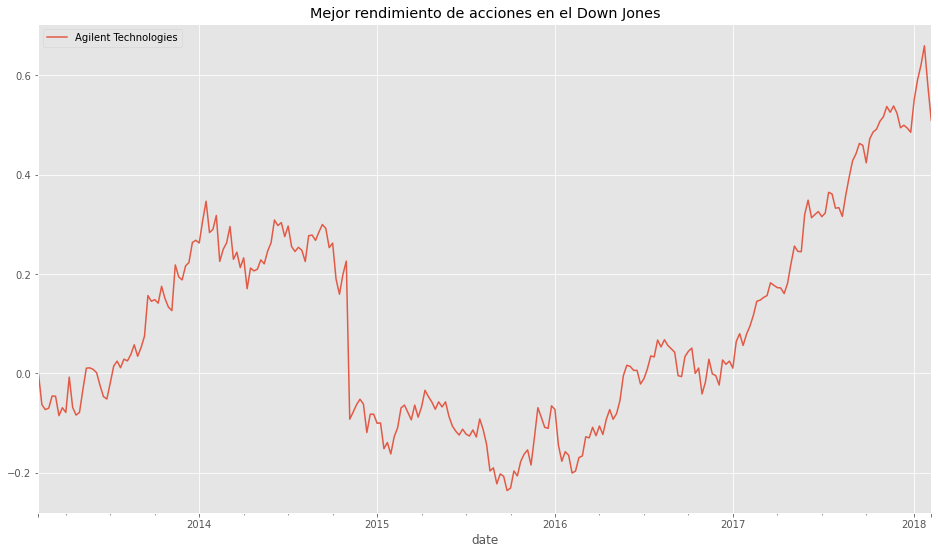

In [ ]:
plot_stock('A', df_acciones=returns)
plt.title('Mejor rendimiento de acciones en el Down Jones')
plt.legend();

####Las peores

In [ ]:
print('Las cinco peores rendimientos de las acciones Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in worst_dow.index.tolist()]}, index = worst_dow.index)
worst_dow = pd.concat((worst_dow, names), axis=1)
worst_dow

Las cinco peores rendimientos de las acciones Dow Jones


,2018-02-11 00:00:00,name
symbol,,
A,NaN,Agilent Technologies
AAL,NaN,American Airlines Group
AAP,NaN,Advance Auto Parts
AAPL,NaN,Apple
ABBV,NaN,AbbVie


#DATOS DE MERCADEO DE VALORES (Acciones de Ubisoft)

---
Vamos a aplicar el algoritmo sobre un conjunto de datos de las acciones de XXX en bolsa de Estados unidos, donde bucaremos :


*   la señal CLOSE (precio de cierre diario) 
*   la señal VOLUME (número de acciones que han cambiado de manos a lo largo de dicho período de tiempo).


https://es-us.finanzas.yahoo.com/


##Importando librerías generales

### Instalando paquetes

In [ ]:
!pip install kora -q
!apt install chromium-chromedriver
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (99.0.4844.51-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import requests # libreria para manejar pedidos internet
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##Descargando data usando Web-scrawping

###Consumiendo data (web scraping) 



*   Wikipedia



In [ ]:
UrlWeb="https://es.wikipedia.org/wiki/Departamentos_de_Colombia"
ClassName="wikitable sortable jquery-tablesorter"                                                          #clase de la tabla 



*   Finanzas Yahoo Oil



In [ ]:
UrlWeb = "https://es-us.finanzas.yahoo.com/quote/CL%3DF/history?period1=1609459200&period2=1647475200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
ClassName = "W(100%) M(0)"

* Finanzas Yahoo Ubisoft

In [ ]:
UrlWeb= "https://es-us.finanzas.yahoo.com/quote/UBI.PA/history?period1=1577836800&period2=1647561600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true"
ClassName="W(100%) M(0)"     

¿Que pagina estoy usando?



In [ ]:
print(f'Web: {UrlWeb}')
print(f'Class: {ClassName}')

Web: https://es-us.finanzas.yahoo.com/quote/UBI.PA/history?period1=1577836800&period2=1647561600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true
Class: W(100%) M(0)


####Op1-con BeautifulSoup

In [ ]:
response=requests.get(UrlWeb)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
tabla= soup.find_all(class_=ClassName)
df_list_table=pd.read_html(str(tabla))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
dfs=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe
#df.to_csv('dataAcciones.csv', index_label='row')
df.head()

####Opt2-con Selenium (cuando bloquean las páginas para robots)

---
A diferencia de Scrapy y de BeautifulSoup, Selenium no trabaja con el texto fuente en HTML de la web en cuestión, sino que carga la página en un navegador sin interfaz de usuario que crea un DOM ( Document Object Model-modelo de objetos de documento). En este navegador se puede simular clic's 
*   URL → Solicitud HTTP → HTML → Selenium → DOM


In [ ]:
from kora.selenium import wd
wd.get(UrlWeb)
soup = BeautifulSoup(wd.page_source, 'html.parser') 

In [ ]:
tabla= soup.find_all(class_=ClassName)
df_list_table=pd.read_html(str(tabla))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe

In [ ]:
#df.head(10)                                                       #LAS PRIMERAS FILAS
df.tail(10)                                                         #Las ultimas filas

,Fecha,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen
91,16 jun 2020,68.48,70.30,66.90,69.54,69.54,3207742
92,09 jun 2020,67.46,69.60,65.06,68.30,68.30,2068454
93,02 jun 2020,70.58,70.68,65.42,67.08,67.08,2566594
94,26 may 2020,69.56,70.90,65.62,70.12,70.12,2726737
95,19 may 2020,66.00,72.74,65.88,69.80,69.80,2205110
96,12 may 2020,69.54,70.18,63.56,66.94,66.94,2782150
97,05 may 2020,71.12,74.60,69.66,70.30,70.30,1762304
98,28 abr 2020,69.30,70.80,66.00,70.56,70.56,1577212
99,21 abr 2020,67.00,71.22,65.18,69.28,69.28,1816635
100,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...,*Precio de cierre ajustado para división de ac...


In [ ]:
#tenemosque borrar la ultima fila
df = df[:-1]

Comprobamos que esa ultima columna(100) ya no se muestra

In [ ]:
df.tail(10)

,Fecha,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen
90,23 jun 2020,69.24,73.46,68.50,73.40,73.40,2782200
91,16 jun 2020,68.48,70.30,66.90,69.54,69.54,3207742
92,09 jun 2020,67.46,69.60,65.06,68.30,68.30,2068454
93,02 jun 2020,70.58,70.68,65.42,67.08,67.08,2566594
94,26 may 2020,69.56,70.90,65.62,70.12,70.12,2726737
95,19 may 2020,66.00,72.74,65.88,69.80,69.80,2205110
96,12 may 2020,69.54,70.18,63.56,66.94,66.94,2782150
97,05 may 2020,71.12,74.60,69.66,70.30,70.30,1762304
98,28 abr 2020,69.30,70.80,66.00,70.56,70.56,1577212
99,21 abr 2020,67.00,71.22,65.18,69.28,69.28,1816635


##Conociendo los datos descargados

In [ ]:
print(df.info())
print("____________describe____________\n",df.describe())
print("____________nulos?____________\n",df.isnull().sum())
#print("Rows, Cols->",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              100 non-null    object
 1   Abrir              100 non-null    object
 2   Alto               100 non-null    object
 3   Bajo               100 non-null    object
 4   Cierre*            100 non-null    object
 5   Cierre ajustado**  100 non-null    object
 6   Volumen            100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB
None
____________describe____________
               Fecha  Abrir   Alto   Bajo Cierre* Cierre ajustado**  Volumen
count           100    100    100    100     100               100      100
unique          100     97     97     97      96                96      100
top     16 mar 2022  67.00  79.40  66.00   63.98             63.98  2513121
freq              1      2      2      2       2                 2        1
____________nul

###Normalización de los datos.

---
Como ocurre con cualquier algoritmo de Machine Learning que utilice funciones de distancia, los datos deben ser normalizados antes de aplicarles el algoritmo:
*   conversión de datos de object a int/float o dateime
*   eliminar campos que no usaremos
*   En este caso utilizaremos la función MinMaxScaler() que normaliza todos los datos entre [0, 1].


####Convertimos los campos object a datetime o numeric (int/float)

In [ ]:
df['Fecha']= df['Fecha'].str.replace(' ene ','/01/')
df['Fecha']= df['Fecha'].str.replace(' feb ','/02/')
df['Fecha']= df['Fecha'].str.replace(' mar ','/03/')
df['Fecha']= df['Fecha'].str.replace(' abr ','/04/')
df['Fecha']= df['Fecha'].str.replace(' may ','/05/')
df['Fecha']= df['Fecha'].str.replace(' jun ','/06/')
df['Fecha']= df['Fecha'].str.replace(' jul ','/07/')
df['Fecha']= df['Fecha'].str.replace(' ago ','/08/')
df['Fecha']= df['Fecha'].str.replace(' sep ','/09/')
df['Fecha']= df['Fecha'].str.replace(' oct ','/10/')
df['Fecha']= df['Fecha'].str.replace(' nov ','/11/')
df['Fecha']= df['Fecha'].str.replace(' dic ','/12/')

Revisamos que se hayan convertido
---
Aun los datos deben aparecer como object

In [ ]:
df.head(10)

,Fecha,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen
0,16/03/2022,38.35,40.23,37.90,39.74,39.74,2513121
1,09/03/2022,40.78,42.82,37.71,37.80,37.80,3193155
2,02/03/2022,47.14,48.18,39.25,39.60,39.60,3326608
3,23/02/2022,47.23,48.72,44.39,47.32,47.32,3542617
4,16/02/2022,48.73,48.88,43.25,47.29,47.29,3958608
5,09/02/2022,50.64,51.90,47.94,48.49,48.49,3225604
6,02/02/2022,52.12,52.14,49.31,50.44,50.44,2244226
7,26/01/2022,47.65,52.68,47.30,52.28,52.28,2963690
8,19/01/2022,49.98,54.56,47.53,47.53,47.53,4992450
9,12/01/2022,44.86,50.88,43.98,50.44,50.44,4117191


Convertimos los datos de tipo **object** a **date**(O fecha valida)

In [ ]:
df['Fecha']=pd.to_datetime(df['Fecha'], dayfirst = True)        # Convertimos el campo FECHA en tipo DATETIME
df['Abrir'] = pd.to_numeric(df['Abrir'])                        #  convertimos el campo a numerico 
df['Alto'] = pd.to_numeric(df['Alto'])
df['Bajo'] = pd.to_numeric(df['Bajo'])
df['Cierre*'] = pd.to_numeric(df['Cierre*'])
df['Cierre ajustado**'] = pd.to_numeric(df['Cierre ajustado**'])
df['Volumen'] = pd.to_numeric(df['Volumen'])

Comprabamos

In [ ]:
print(df.info())
print("____________describe____________\n",df.describe())
print("____________nulos?____________\n",df.isnull().sum())
#print("Rows, Cols->",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              100 non-null    datetime64[ns]
 1   Abrir              100 non-null    float64       
 2   Alto               100 non-null    float64       
 3   Bajo               100 non-null    float64       
 4   Cierre*            100 non-null    float64       
 5   Cierre ajustado**  100 non-null    float64       
 6   Volumen            100 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.6 KB
None
____________describe____________
             Abrir        Alto       Bajo     Cierre*  Cierre ajustado**  \
count  100.000000  100.000000  100.00000  100.000000         100.000000   
mean    62.925300   64.988500   60.46950   62.613400          62.613400   
std     12.729887   13.186319   12.54112   13.003701          13.0037

In [ ]:
#salvamos el dataFrame 
df.to_csv('Precio_ubisoft_2021_2022.csv', index_label='row')

####Eliminando columnas que no necesitaremos (por ahora)

---
extraemos la columna DATE (fecha) que no usaremos en el algoritmo k-means. Antes de extraerla la guardaremos en la variable dates, ya que volveremos a insertarla en nuestro dataframe tras aplicar el algoritmo


In [ ]:
#borrar nulos o no?
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
# Eliminamos columna de fecha que no usaremos en el algoritmo.
dates = df['Fecha'] # Guardamos la columna Date.
df = df.drop('Fecha', 1) # Borramos la columna del dataframe.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


####normaliza todos los datos entre [0, 1].

---
En este caso utilizaremos la función MinMaxScaler()


In [ ]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0:'Abrir',1:'Alto',2:'Bajo',3:'Cierre*',4: 'Cierre ajustado**', 5: 'Volumen'})

In [ ]:
df_escalado.head()
#df_escalado.isnull().sum()

,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen
0,0.000000,0.000000,0.004191,0.041720,0.041720,0.318343
1,0.052792,0.054037,0.000000,0.000000,0.000000,0.434736
2,0.190962,0.165867,0.033973,0.038710,0.038710,0.457578
3,0.192918,0.177133,0.147364,0.204731,0.204731,0.494550
4,0.225505,0.180472,0.122215,0.204086,0.204086,0.565750


###Representación gráfica de los datos.

---


*   Ahora podemos echar un vistazo a la representación gráfica de nuestros datos. En el eje x representaremos el precio de cierre (CLOSE) y en el eje y el volumen (VOLUMEN)
*   VAMOS A representar gráficamente los datos normalizados, pero que, si hubiésemos representado los datos sin normalizar la gráfica sería exactamente igual, con la única diferencia que la escala de los ejes sería diferente.





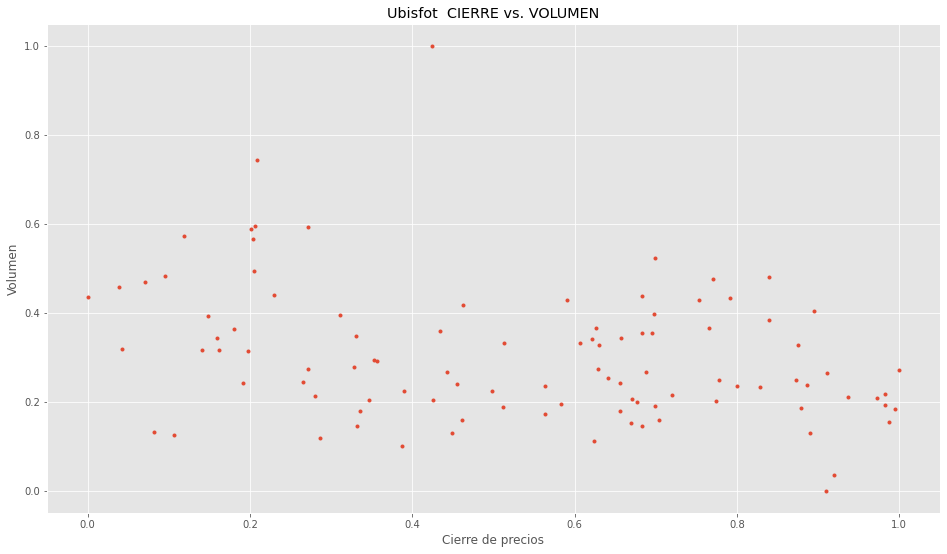

In [ ]:
#%% Representación gráfica de los datos.
x = df_escalado['Cierre*'].values
y = df_escalado['Volumen'].values
plt.xlabel('Cierre de precios')
plt.ylabel('Volumen')
plt.title('Ubisfot  CIERRE vs. VOLUMEN')
plt.plot(x,y,'o',markersize=3)

##Aplicación de k-means.

---
El primer paso antes de aplicar k-means es decidir qué valor de k (número de clústeres) queremos usar:


1.    Una forma de elegir este valor k es por criterio propio: si conocemos bien la distribución de nuestros datos y queremos “forzar” un número determinado de clústeres simplemente lo elegimos
2.    realizar una gráfica elbow o de codo para determinar el número óptimo de clústeres. Hacemos una iteración de k-means variando el valor de k, de forma que representamos en el eje x dicho valor de k y en el eje y la suma de los errores cuadráticos (SSE). De esta forma podemos elegir el valor de k dónde se produce el “codo”   (**----ESTA ME GUSTA MÁS---**)




###Realizar una gráfica elbow o de codo

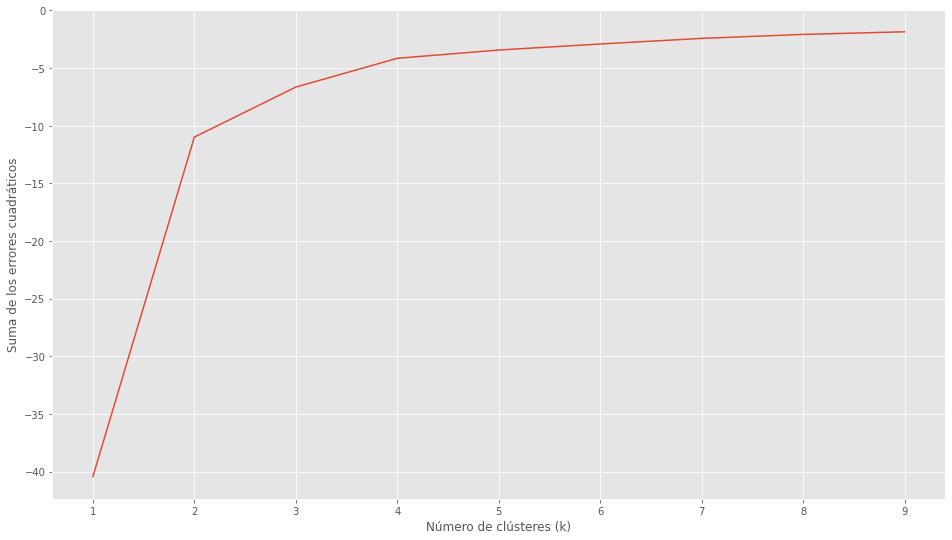

In [ ]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 10) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

####NOTA: 

---


**No hay una solución, un valor de k, más correcto que otro**, ya que el objetivo de una clusterización con k-means es obtener información útil nuestros datos, por lo que **nuestra interpretación a posteriori de los clústeres creados marcará la calidad de nuestra solución** escogida

###Aplicar el algoritmo de k-mean

In [ ]:
#%% Aplicación de k-means con k = 3.
kmeans = KMeans(n_clusters=3).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)   #coordenadas de los centroides

[[0.22838219 0.21411856 0.19211667 0.22316768 0.22316768 0.36764708]
 [0.60888384 0.58405153 0.58160951 0.61058726 0.61058726 0.26964076]
 [0.88304729 0.87313095 0.85072432 0.88716846 0.88716846 0.2557559 ]]


###Etiquetado de datos.

---
asignamos cada registro de nuestro dataset a uno de los clústers


In [ ]:
#%% Etiquetamos nuestro dataframe.
labels = kmeans.predict(df_escalado)   #generamos las etiquetas de cada clouster
df['label'] = labels                   #añadimos la columna “label” a nuestro dataframe original

In [ ]:
# No ejecutar dos veces
df.insert(0, 'Date', dates)           #%% Añadimos la columna de fecha

In [ ]:
df.head(100)

,Date,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen,label
0,2022-03-16,38.35,40.23,37.90,39.74,39.74,2513121,0
1,2022-03-09,40.78,42.82,37.71,37.80,37.80,3193155,0
2,2022-03-02,47.14,48.18,39.25,39.60,39.60,3326608,0
3,2022-02-23,47.23,48.72,44.39,47.32,47.32,3542617,0
4,2022-02-16,48.73,48.88,43.25,47.29,47.29,3958608,0
...,...,...,...,...,...,...,...,...
95,2020-05-19,66.00,72.74,65.88,69.80,69.80,2205110,1
96,2020-05-12,69.54,70.18,63.56,66.94,66.94,2782150,1
97,2020-05-05,71.12,74.60,69.66,70.30,70.30,1762304,1
98,2020-04-28,69.30,70.80,66.00,70.56,70.56,1577212,1


##Representación gráfica de los clústeres k-means.

---
Una vez con los datos etiquetados, podemos visualizar gráficamente en dos dimensiones el clustering realizado por k-means, ya que hemos usado sólo dos variable


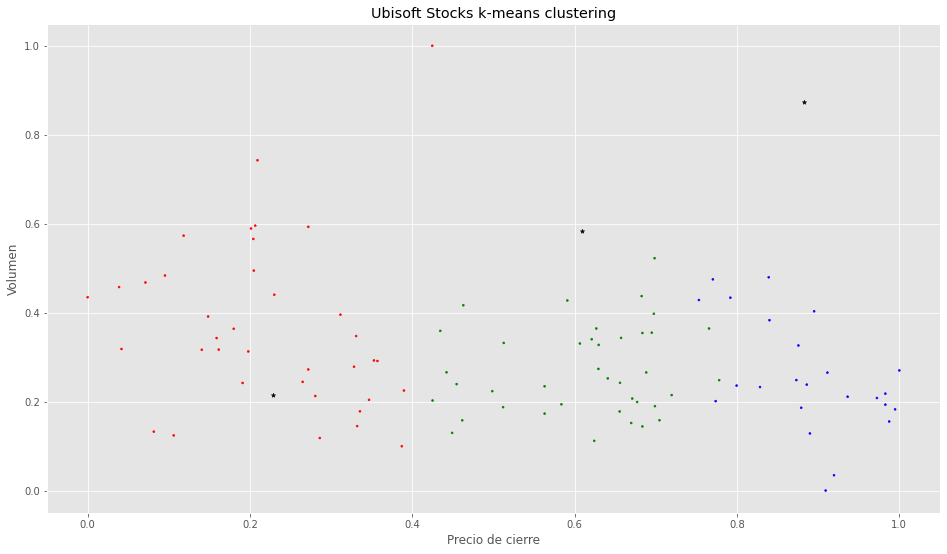

In [ ]:
#%% Plot k-means clustering.
colores=['red','green','blue']
asignar=[]
for row in labels:
  asignar.append(colores[row])
plt.scatter(x, y, c=asignar, s=4)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='black', s=20) # Marco centroides.
plt.xlabel('Precio de cierre')
plt.ylabel('Volumen')
plt.title('Ubisoft Stocks k-means clustering')
plt.show()

**Que podemos inferir???**